# About The Study and Dataset
***
According to measurements of 2021, breast cancer became the most frequent type of cancer with 2.3 million diagnoses. Early diagnosis has a critical role in the treatment of breast cancer. According to studies, the success rate of pathologists is 75% [1] and the concordance of diagnosis is 75,3% [2].

This study aims about classifying the histopathological images as benign or malignant with the possible highest accuracy and fastest way. During this study, I have tried 18 different models with Tensorflow and Pytorch libraries with different epoch sizes, activation functions and optimisation functions. This file includes the last and the best version of training and test attempts. Unfortunately, my thesis is not available in English.

[1] Vo, D. M., Nguyen, N. Q., & Lee, S. W. (2019). Classification of breast cancer histology images using incremental boosting convolution networks. Information Sciences, 482, 123-138.

[2] Elmore, J. G., Longton, G. M., Carney, P. A., Geller, B. M., Onega, T., Tosteson, A. N., ... & Weaver, D. L. (2015). Diagnostic concordance among pathologists interpreting breast biopsy specimens. Jama, 313(11), 1122-1132.

**Dataset:** BreakHis Dataset

**Programming Language:** Python

**Year of Study:** 2021

## Results of the Study
- 13 ms CPU time per image
- 87,62% accuracy rate and 0,83 AUC score for 200X magnification rate images.
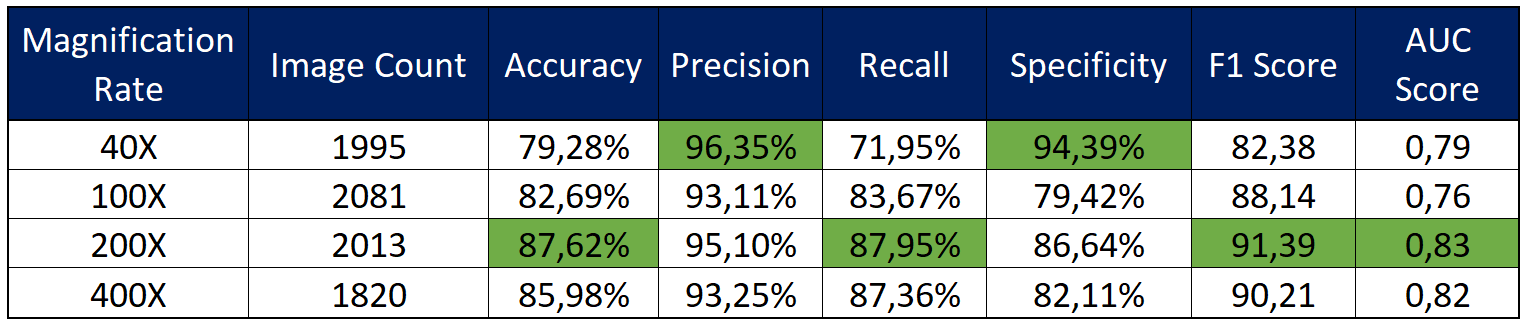

## Model
***
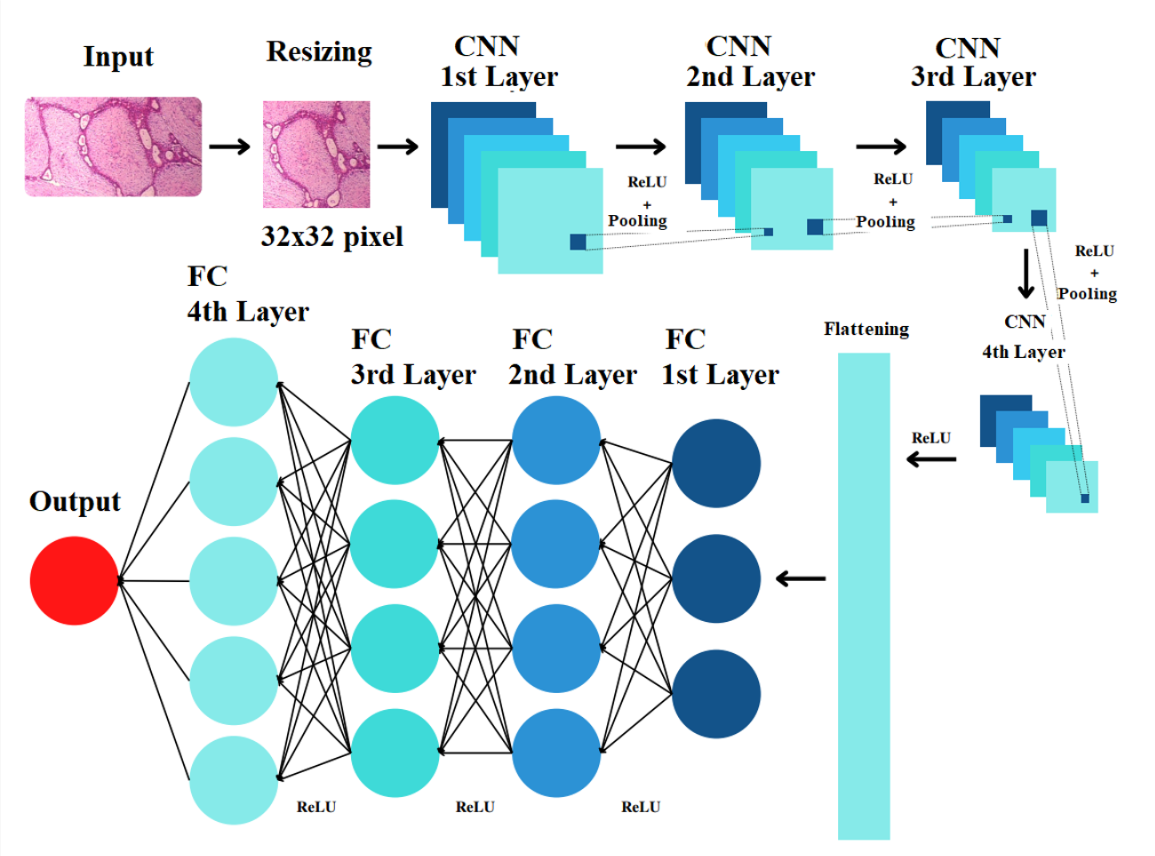

# Importing Libraries and Dataset

In [2]:
import torch
import torchvision.transforms as transforms
import torchvision
import os
import pandas as pd
from torch.utils.data import (Dataset, DataLoader)
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
import warnings
warnings.filterwarnings('ignore')

Creating a class for importing the dataset, returning labels and images

In [3]:
class datasetCreator(Dataset):
  def __init__(self,csv_file, root_dir,transform=None):
    self.annotations = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform
  def __len__(self):
    return len(self.annotations)
  def __getitem__(self,index):
    img_path = os.path.join(self.root_dir, self.annotations.iloc[index,0])
    image = io.imread(img_path)
    y_label = torch.tensor(int(self.annotations.iloc[index,1]))
    
    if self.transform:
      image = self.transform(image)

    return(image, y_label)

In [4]:
dataset = datasetCreator(csv_file=r"C:\testDataset400X-pyt\bc.csv", # Importing the paths of each file.
               root_dir = r"C:/testDataset400X-pyt/",
               transform= torchvision.transforms.Compose([
                   transforms.ToTensor(),                                 # Convering to tensor
                   transforms.Resize(size=(32,32)),                       # Resizing images
                   transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))  # Normalizing images
               ]))
dataset

Splitting the dataset as train and test datasets. Converting the datasets to DataLoader

In [5]:
train_set, test_set = torch.utils.data.random_split(dataset,[1455,364])
train_loader = DataLoader(dataset = train_set, batch_size = 1, shuffle=False)
test_loader = DataLoader(dataset = test_set, batch_size = 1, shuffle=False)

Specifying the batch size and classes. Checking if images load correctly. Starting the iteration, loading the first image and label.

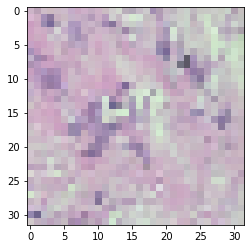

Benign
torch.Size([1, 3, 32, 32])


In [6]:
batch_size = 1
classes = ["Benign","Malignant"]

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1, 2, 0)))
    plt.show()
    
dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))
print(images.size())

In [7]:
import torch.nn as nn
import torch.optim as optim
import time

# Creating the Training Model

In [8]:
model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=4, kernel_size=(5,5)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2)),
    nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(3,3)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2)),
    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3,3)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2)),
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(2,2)),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=32, out_features=50),
    nn.ReLU(),
    nn.Linear(in_features=50, out_features=50),
    nn.ReLU(),
    nn.Linear(in_features=50, out_features=100),
    nn.ReLU(),
    nn.Linear(in_features=100, out_features=2)
)

Checking the model

In [9]:
model

Sequential(
  (0): Conv2d(3, 4, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
  (10): ReLU()
  (11): Flatten(start_dim=1, end_dim=-1)
  (12): Linear(in_features=32, out_features=50, bias=True)
  (13): ReLU()
  (14): Linear(in_features=50, out_features=50, bias=True)
  (15): ReLU()
  (16): Linear(in_features=50, out_features=100, bias=True)
  (17): ReLU()
  (18): Linear(in_features=100, out_features=2, bias=True)
)

# Training of the Model

In [9]:
start_time = time.time()                                       # Getting the start time of training.
optimizer = torch.optim.Adamax(model.parameters(),lr = 0.0001) # Setting the adamax optimization algorithm with learning rate parameter
error = torch.nn.CrossEntropyLoss()                            # Cross entropy loss function
epoch = 30                                                     # Definition of epoch
train_acc_list, wrong_list, loss_list  = [], [], []            # Setting the lists for the following calculations.
count, total, correct_count, wrong_count, epoch_count = 0,0,0,0,0 # Setting the counters for the following calculations.

for i in range(epoch):
    epoch_count += 1
    for i,(images,label) in enumerate (train_loader):
        optimizer.zero_grad()
        out = model(images)
        loss = error(out,label)
        loss.backward()
        optimizer.step()
        count += 1
        
        if count % 100 == 0:
            total = 0
            correct_count = 0
            wrong_count = 0
            
            for image,labels in test_loader:
                test_out = model(images)
                pred = torch.max(test_out.data,1)[1]
                total += len(label)
                correct_count += (pred == labels).sum()
                wrong_count += (pred != labels).sum()
            dogruluk_oran = 100 * (correct_count/float(total))
            hata_oran = 100 * (wrong_count/float(total))
            train_acc_list.append(dogruluk_oran)
            wrong_list.append(hata_oran)
            loss_list.append(loss.data)
            print("#-----------------------------# Epoch: {} İter: {} #-----------------------------#".format(epoch_count,count))
            print("Doğruluk: {}".format(dogruluk_oran))
            print("Hata: {}".format(hata_oran))
            print("Loss: {}".format(loss.data))
end_time = time.time()
timeresult = end_time - start_time
hours = (timeresult // 3600)
timeresult -= (timeresult * 3600)
minutes = (timeresult // 60)
timeresult -= (minutes * 60)
seconds = timeresult
print("Süre: {} saat {} dakika {} saniye (Toplam {} saniye)".format(hours,minutes,seconds,end_time-start_time))

#-----------------------------# Epoch: 1 İter: 100 #-----------------------------#
Doğruluk: 68.4065933227539
Hata: 31.593406677246094
Loss: 0.6066742539405823
#-----------------------------# Epoch: 1 İter: 200 #-----------------------------#
Doğruluk: 68.4065933227539
Hata: 31.593406677246094
Loss: 0.5830816626548767
#-----------------------------# Epoch: 1 İter: 300 #-----------------------------#
Doğruluk: 68.4065933227539
Hata: 31.593406677246094
Loss: 0.5507574081420898
#-----------------------------# Epoch: 1 İter: 400 #-----------------------------#
Doğruluk: 68.4065933227539
Hata: 31.593406677246094
Loss: 0.5402731895446777
#-----------------------------# Epoch: 1 İter: 500 #-----------------------------#
Doğruluk: 68.4065933227539
Hata: 31.593406677246094
Loss: 0.5232236981391907
#-----------------------------# Epoch: 1 İter: 600 #-----------------------------#
Doğruluk: 68.4065933227539
Hata: 31.593406677246094
Loss: 0.9116014242172241
#-----------------------------# Epoch: 1

#-----------------------------# Epoch: 4 İter: 5200 #-----------------------------#
Doğruluk: 68.4065933227539
Hata: 31.593406677246094
Loss: 1.1348795890808105
#-----------------------------# Epoch: 4 İter: 5300 #-----------------------------#
Doğruluk: 68.4065933227539
Hata: 31.593406677246094
Loss: 0.2123381346464157
#-----------------------------# Epoch: 4 İter: 5400 #-----------------------------#
Doğruluk: 68.4065933227539
Hata: 31.593406677246094
Loss: 0.30754396319389343
#-----------------------------# Epoch: 4 İter: 5500 #-----------------------------#
Doğruluk: 68.4065933227539
Hata: 31.593406677246094
Loss: 0.913652777671814
#-----------------------------# Epoch: 4 İter: 5600 #-----------------------------#
Doğruluk: 68.4065933227539
Hata: 31.593406677246094
Loss: 0.29624947905540466
#-----------------------------# Epoch: 4 İter: 5700 #-----------------------------#
Doğruluk: 68.4065933227539
Hata: 31.593406677246094
Loss: 0.9915142059326172
#-----------------------------# E

#-----------------------------# Epoch: 8 İter: 10300 #-----------------------------#
Doğruluk: 68.4065933227539
Hata: 31.593406677246094
Loss: 0.1524220108985901
#-----------------------------# Epoch: 8 İter: 10400 #-----------------------------#
Doğruluk: 31.593406677246094
Hata: 68.4065933227539
Loss: 0.4345209300518036
#-----------------------------# Epoch: 8 İter: 10500 #-----------------------------#
Doğruluk: 68.4065933227539
Hata: 31.593406677246094
Loss: 0.08523137122392654
#-----------------------------# Epoch: 8 İter: 10600 #-----------------------------#
Doğruluk: 31.593406677246094
Hata: 68.4065933227539
Loss: 0.5210086703300476
#-----------------------------# Epoch: 8 İter: 10700 #-----------------------------#
Doğruluk: 68.4065933227539
Hata: 31.593406677246094
Loss: 0.09602130204439163
#-----------------------------# Epoch: 8 İter: 10800 #-----------------------------#
Doğruluk: 68.4065933227539
Hata: 31.593406677246094
Loss: 0.5719846487045288
#-------------------------

#-----------------------------# Epoch: 11 İter: 15400 #-----------------------------#
Doğruluk: 68.4065933227539
Hata: 31.593406677246094
Loss: 1.9764254093170166
#-----------------------------# Epoch: 11 İter: 15500 #-----------------------------#
Doğruluk: 68.4065933227539
Hata: 31.593406677246094
Loss: 0.11091893166303635
#-----------------------------# Epoch: 11 İter: 15600 #-----------------------------#
Doğruluk: 31.593406677246094
Hata: 68.4065933227539
Loss: 1.6118701696395874
#-----------------------------# Epoch: 11 İter: 15700 #-----------------------------#
Doğruluk: 68.4065933227539
Hata: 31.593406677246094
Loss: 0.11213812232017517
#-----------------------------# Epoch: 11 İter: 15800 #-----------------------------#
Doğruluk: 68.4065933227539
Hata: 31.593406677246094
Loss: 0.09438297152519226
#-----------------------------# Epoch: 11 İter: 15900 #-----------------------------#
Doğruluk: 68.4065933227539
Hata: 31.593406677246094
Loss: 0.10716470330953598
#-----------------

#-----------------------------# Epoch: 15 İter: 20500 #-----------------------------#
Doğruluk: 68.4065933227539
Hata: 31.593406677246094
Loss: 0.12714800238609314
#-----------------------------# Epoch: 15 İter: 20600 #-----------------------------#
Doğruluk: 68.4065933227539
Hata: 31.593406677246094
Loss: 0.13747535645961761
#-----------------------------# Epoch: 15 İter: 20700 #-----------------------------#
Doğruluk: 68.4065933227539
Hata: 31.593406677246094
Loss: 0.033814504742622375
#-----------------------------# Epoch: 15 İter: 20800 #-----------------------------#
Doğruluk: 68.4065933227539
Hata: 31.593406677246094
Loss: 0.060552701354026794
#-----------------------------# Epoch: 15 İter: 20900 #-----------------------------#
Doğruluk: 31.593406677246094
Hata: 68.4065933227539
Loss: 0.1747872680425644
#-----------------------------# Epoch: 15 İter: 21000 #-----------------------------#
Doğruluk: 68.4065933227539
Hata: 31.593406677246094
Loss: 0.09641000628471375
#--------------

#-----------------------------# Epoch: 18 İter: 25600 #-----------------------------#
Doğruluk: 68.4065933227539
Hata: 31.593406677246094
Loss: 0.08398844301700592
#-----------------------------# Epoch: 18 İter: 25700 #-----------------------------#
Doğruluk: 68.4065933227539
Hata: 31.593406677246094
Loss: 2.084961414337158
#-----------------------------# Epoch: 18 İter: 25800 #-----------------------------#
Doğruluk: 68.4065933227539
Hata: 31.593406677246094
Loss: 0.11141962558031082
#-----------------------------# Epoch: 18 İter: 25900 #-----------------------------#
Doğruluk: 68.4065933227539
Hata: 31.593406677246094
Loss: 0.06996969133615494
#-----------------------------# Epoch: 18 İter: 26000 #-----------------------------#
Doğruluk: 68.4065933227539
Hata: 31.593406677246094
Loss: 0.12589558959007263
#-----------------------------# Epoch: 18 İter: 26100 #-----------------------------#
Doğruluk: 68.4065933227539
Hata: 31.593406677246094
Loss: 0.10563153773546219
#-----------------

#-----------------------------# Epoch: 22 İter: 30700 #-----------------------------#
Doğruluk: 68.4065933227539
Hata: 31.593406677246094
Loss: 0.12013193219900131
#-----------------------------# Epoch: 22 İter: 30800 #-----------------------------#
Doğruluk: 68.4065933227539
Hata: 31.593406677246094
Loss: 2.8459482192993164
#-----------------------------# Epoch: 22 İter: 30900 #-----------------------------#
Doğruluk: 68.4065933227539
Hata: 31.593406677246094
Loss: 0.07416989654302597
#-----------------------------# Epoch: 22 İter: 31000 #-----------------------------#
Doğruluk: 68.4065933227539
Hata: 31.593406677246094
Loss: 0.20871306955814362
#-----------------------------# Epoch: 22 İter: 31100 #-----------------------------#
Doğruluk: 31.593406677246094
Hata: 68.4065933227539
Loss: 0.24925729632377625
#-----------------------------# Epoch: 22 İter: 31200 #-----------------------------#
Doğruluk: 68.4065933227539
Hata: 31.593406677246094
Loss: 0.9001647233963013
#-----------------

#-----------------------------# Epoch: 25 İter: 35800 #-----------------------------#
Doğruluk: 68.4065933227539
Hata: 31.593406677246094
Loss: 2.1771528720855713
#-----------------------------# Epoch: 25 İter: 35900 #-----------------------------#
Doğruluk: 68.4065933227539
Hata: 31.593406677246094
Loss: 0.08351801335811615
#-----------------------------# Epoch: 25 İter: 36000 #-----------------------------#
Doğruluk: 68.4065933227539
Hata: 31.593406677246094
Loss: 1.9125490188598633
#-----------------------------# Epoch: 25 İter: 36100 #-----------------------------#
Doğruluk: 68.4065933227539
Hata: 31.593406677246094
Loss: 1.9256964921951294
#-----------------------------# Epoch: 25 İter: 36200 #-----------------------------#
Doğruluk: 68.4065933227539
Hata: 31.593406677246094
Loss: 0.11952303349971771
#-----------------------------# Epoch: 25 İter: 36300 #-----------------------------#
Doğruluk: 31.593406677246094
Hata: 68.4065933227539
Loss: 0.2552929222583771
#-------------------

#-----------------------------# Epoch: 29 İter: 40900 #-----------------------------#
Doğruluk: 68.4065933227539
Hata: 31.593406677246094
Loss: 0.0888424962759018
#-----------------------------# Epoch: 29 İter: 41000 #-----------------------------#
Doğruluk: 68.4065933227539
Hata: 31.593406677246094
Loss: 0.18278561532497406
#-----------------------------# Epoch: 29 İter: 41100 #-----------------------------#
Doğruluk: 68.4065933227539
Hata: 31.593406677246094
Loss: 0.1402626782655716
#-----------------------------# Epoch: 29 İter: 41200 #-----------------------------#
Doğruluk: 68.4065933227539
Hata: 31.593406677246094
Loss: 0.1725885272026062
#-----------------------------# Epoch: 29 İter: 41300 #-----------------------------#
Doğruluk: 68.4065933227539
Hata: 31.593406677246094
Loss: 0.24038094282150269
#-----------------------------# Epoch: 29 İter: 41400 #-----------------------------#
Doğruluk: 68.4065933227539
Hata: 31.593406677246094
Loss: 0.13397985696792603
#------------------

# Loading the Model and Optimizer

In [27]:
model2 = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=4, kernel_size=(5,5)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2)),
    nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(3,3)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2)),
    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3,3)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2)),
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(2,2)),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=32, out_features=50),
    nn.ReLU(),
    nn.Linear(in_features=50, out_features=50),
    nn.ReLU(),
    nn.Linear(in_features=50, out_features=100),
    nn.ReLU(),
    nn.Linear(in_features=100, out_features=2)
)
checkpoint = torch.load(r'C:\Users\Barış\Desktop\pytorch\pyt-test6-400X.pth')
optimizer = torch.optim.Adamax(model.parameters())
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])

In [99]:
from importlib import reload
plt=reload(plt)

# Test for 400X Magnification Rate Images

In [45]:
firstRunProtector = True
correct_count, wrong_count, total_count, correct_rate = 0,0,0,0
true_positive, true_negative, false_positive, false_negative = 0,0.1,0,0
imageCounter, specificity, precision, recall, f1_score = 0,0,0,0,0
trueLabelList400X, predictedList400X, accuracyList400X, precisionList400X = [],[],[],[]
specificityList400X, recallList400X, imageCounterList400X = [], [], []
model.eval()

with torch.no_grad():
    for x,y in test_loader:
        output = model(x)
        _,prediction = output.max(1)
        correct_count += (prediction==y).sum()
        wrong_count += (prediction!=y).sum()
        if (prediction[0] == 1) and (prediction[0] == y[0]): # tahmin 1, gerçek 1
            true_positive += 1
        elif (prediction[0] == 0) and (prediction[0] == y[0]): # tahmin 0, gerçek 0
            true_negative += 1
        elif (prediction[0] == 0) and (prediction[0] != y[0]): # tahmin 0, gerçek 1
            false_positive += 1
        elif (prediction[0] == 1) and (prediction[0] != y[0]): # tahmin 1, gerçek 0
            false_negative += 1
        trueLabelList400X.append(y[0])
        predictedList400X.append(prediction)
        
        total_count += prediction.size(0)
        imageCounter += 1
        imageCounterList400X.append(imageCounter)
        if firstRunProtector == False:
            correct_rate = (correct_count/total_count)*100
            recall = true_positive / (true_positive + false_negative)
            precision = true_positive / (true_positive + false_positive)
            specificity = true_negative / (true_negative + false_positive)
            f1_score = ((precision * recall) / (precision + recall)) * 2
            
            accuracyList400X.append(correct_rate)
            precisionList400X.append(precision*100)
            recallList400X.append(recall*100)
            specificityList400X.append(specificity*100)
        else:
            firstRunProtector = False
            accuracyList400X.append(0)
            precisionList400X.append(0)
            recallList400X.append(0)
            specificityList400X.append(0)
            pass
    print("Dogruluk: {}/{} Oran: {}".format(correct_count,total_count, correct_rate))
    print("TP: {} TN: {}".format(true_positive, true_negative))
    print("FP: {} FN: {}".format(false_positive, false_negative))
    print("Precision: {}".format(precision*100))
    print("Recall: {}".format(recall*100))
    print("F1 Skoru: {}".format(f1_score*100))
            

Dogruluk: 313/364 Oran: 85.989013671875
TP: 235 TN: 78.1
FP: 17 FN: 34
Precision: 93.25396825396825
Recall: 87.36059479553904
F1 Skoru: 90.21113243761997


# Accuracy Plot of the Test for 400X Magnification Rate Images

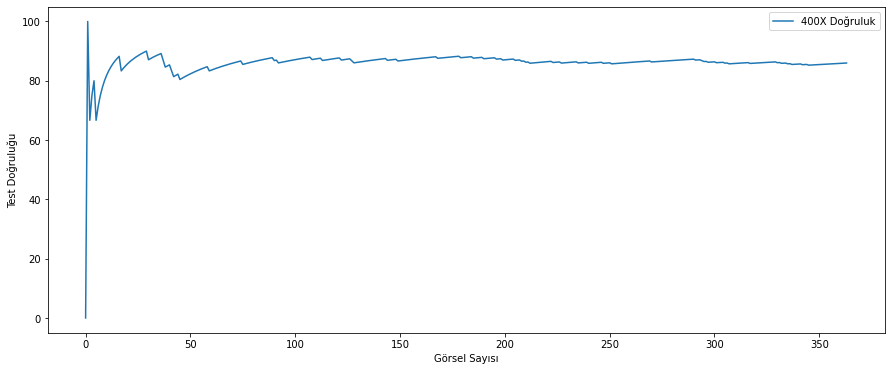

In [46]:
plt.figure(figsize=(15,6))
plt.plot(accuracyList400X,label="400X Doğruluk")
plt.xlabel('Görsel Sayısı') 
plt.ylabel('Test Doğruluğu') # Test Accuracy
plt.legend()

# Recall Plot of the Test for 400X Magnification Rate Images

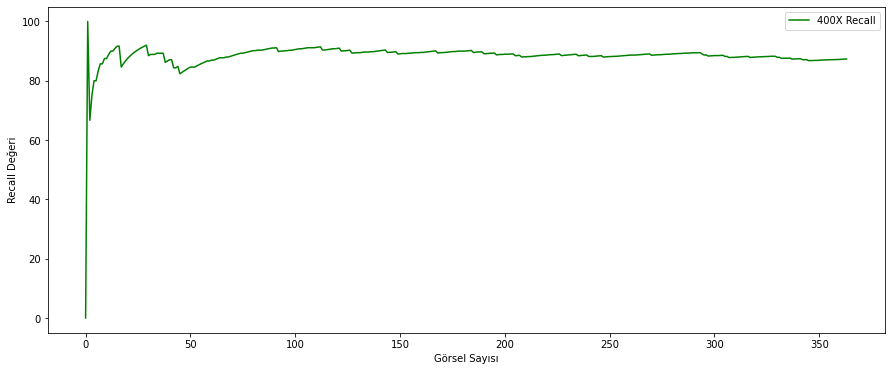

In [47]:
plt.figure(figsize=(15,6))
plt.plot(recallList400X,label="400X Recall", color="g")
plt.xlabel('Görsel Sayısı')
plt.ylabel('Recall Değeri')
plt.legend()

# Precision Plot of the Test for 400X Magnification Rate Images

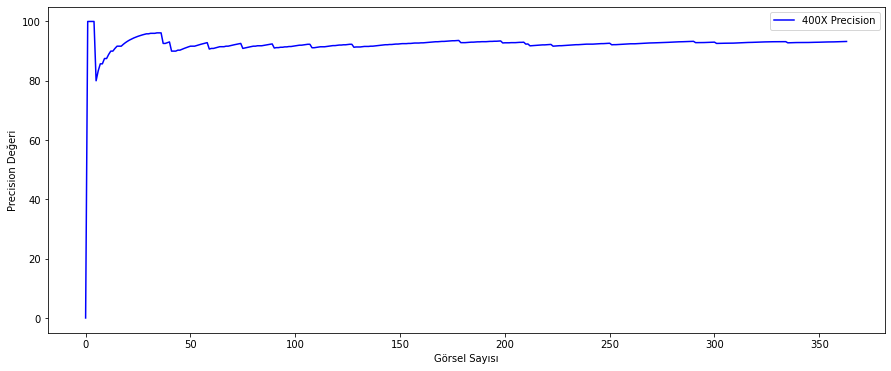

In [48]:
plt.figure(figsize=(15,6))
plt.plot(precisionList400X,label="400X Precision", color="b")
plt.xlabel('Görsel Sayısı')
plt.ylabel('Precision Değeri')
plt.legend()

# Specificity Plot of the Test for 400X Magnification Rate Images

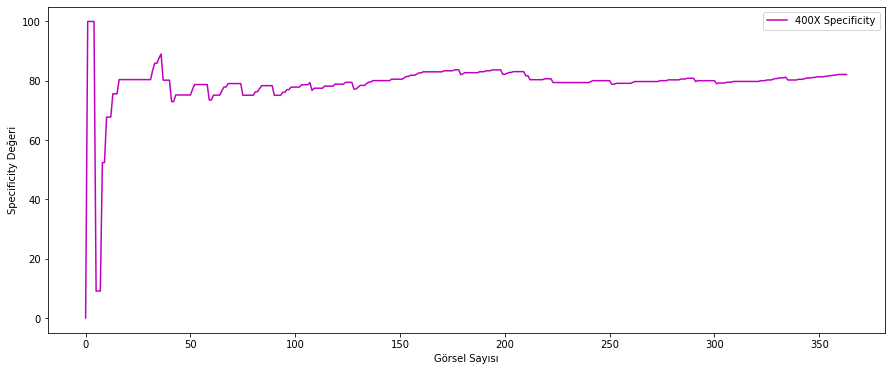

In [49]:
plt.figure(figsize=(15,6))
plt.plot(specificityList400X,label="400X Specificity", color="m")
plt.xlabel('Görsel Sayısı')
plt.ylabel('Specificity Değeri')
plt.legend()

# The Plot for All Metrics

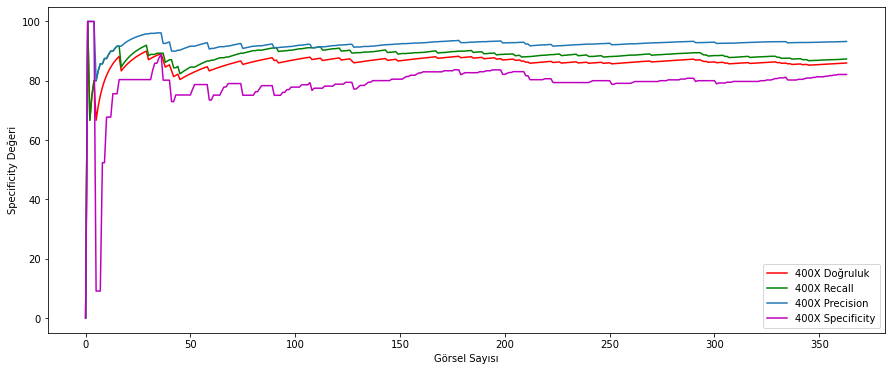

In [52]:
plt.figure(figsize=(15,6))
plt.plot(accuracyList400X,label="400X Doğruluk", color="r")
plt.plot(recallList400X,label="400X Recall", color="g")
plt.plot(precisionList400X,label="400X Precision")
plt.plot(specificityList400X,label="400X Specificity", color="m")
plt.xlabel('Görsel Sayısı')
plt.ylabel('Specificity Değeri')
plt.legend()

# AUC Plot of the Test for 400X Magnification Rate Images

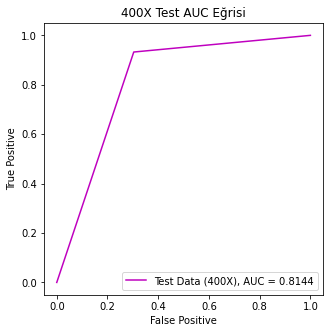

In [58]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr = 0,0
fpr, tpr, thresholds = roc_curve(trueLabelList400X, predictedList400X)
auc = roc_auc_score(trueLabelList400X, predictedList400X)

plt.figure(figsize=(5,5))
plt.title('400X Test AUC Eğrisi')
plt.plot(fpr,tpr,label="Test Data (400X), AUC = "+str(auc)[0:6], color="m")
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.legend()
plt.show()

# Test Results for the Other Datasets

Creting a function for loading the dataset.

In [21]:
def loadsetChanger(selectedDataset):    
    if selectedDataset == "40X":
        newDataset = datasetCreator(csv_file=  r"C:\testDataset40X-pyt\bc.csv",
               root_dir = r"C:\testDataset40X-pyt/",
               transform= torchvision.transforms.Compose([
                   transforms.ToTensor(),
                   transforms.Resize(size=(32,32)),
                   transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
                ]))
        test_loader = DataLoader(dataset = newDataset, batch_size = 1, shuffle=False)
    elif selectedDataset == "100X":
        newDataset = datasetCreator(csv_file= r"C:\testDataset100X-pyt\bc.csv",
               root_dir = r"C:\testDataset100X-pyt/",
               transform= torchvision.transforms.Compose([
                   transforms.ToTensor(),
                   transforms.Resize(size=(32,32)),
                   transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
                ]))
        test_loader = DataLoader(dataset = newDataset, batch_size = 1, shuffle=False)
    elif selectedDataset == "200X":
        newDataset = datasetCreator(csv_file= r"C:\testDataset200X-pyt\bc.csv",
               root_dir = r"C:/testDataset200X-pyt/",
               transform= torchvision.transforms.Compose([
                   transforms.ToTensor(),
                   transforms.Resize(size=(32,32)),
                   transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
                ]))
        test_loader = DataLoader(dataset = newDataset, batch_size = 1, shuffle=False)
    return test_loader, dataset

Creating a function for testing of the dataset

In [59]:
def test(loader, model, dataset):
    test_start_time = time.time()
    firstRunProtector = True
    correct_count, wrong_count, total_count, correct_rate = 0, 0, 0, 0
    true_positive, true_negative, false_positive, false_negative = 0.01, 0.01, 0.01, 0.01
    specificity, precision, recall, f1_score = 0, 0, 0, 0
    imageCounter = 0
    
    imageCounterList = []
    trueLabelList = []
    predictedList = []
    accuracyList = []
    precisionList = []
    specificityList = []
    recallList = []
    specificityList = []
    model.eval()

    with torch.no_grad():
        for x,y in loader:
            output = model(x)
            _,prediction = output.max(1)
            correct_count += (prediction==y).sum()
            wrong_count += (prediction!=y).sum()
            if (prediction[0] == 1) and (prediction[0] == y[0]): # tahmin 1, gerçek 1
                true_positive += 1
            elif (prediction[0] == 0) and (prediction[0] == y[0]): # tahmin 0, gerçek 0
                true_negative += 1
            elif (prediction[0] == 0) and (prediction[0] != y[0]): # tahmin 0, gerçek 1
                false_positive += 1
            elif (prediction[0] == 1) and (prediction[0] != y[0]): # tahmin 1, gerçek 0
                false_negative += 1
            trueLabelList.append(y[0])
            predictedList.append(prediction)

            total_count += prediction.size(0)
            imageCounter += 1
            imageCounterList.append(imageCounter)
            if firstRunProtector == False:
                correct_rate = (correct_count/total_count)*100
                recall = true_positive / (true_positive + false_negative)
                precision = true_positive / (true_positive + false_positive)
                specificity = true_negative / (true_negative + false_positive)
                f1_score = ((precision * recall) / (precision + recall)) * 2

                accuracyList.append(correct_rate)
                precisionList.append(precision*100)
                recallList.append(recall*100)
                specificityList.append(specificity*100)
            else:
                firstRunProtector = False
                accuracyList.append(0)
                precisionList.append(0)
                recallList.append(0)
                specificityList.append(0)
                pass
        firstRunProtector = True
        test_end_time = time.time()
        print("Dogruluk: {}/{} Oran: {}".format(correct_count,total_count, correct_rate)) # Accuracy
        print("TP: {} TN: {}".format(true_positive, true_negative))                       # True Positive, True Negative
        print("FP: {} FN: {}".format(false_positive, false_negative))                     # False Positive, False Negative
        print("Precision: {}".format(precision*100))                                      # Precision
        print("Recall: {}".format(recall*100))                                            # Recall
        print("F1 Skoru: {}".format(f1_score*100))                                        # F1 Score
        print("Test {} saniyede gerçekleştirilmiştir.".format(test_end_time-test_start_time)) # Completion time of the test
        return trueLabelList ,predictedList, accuracyList, precisionList, recallList, imageCounterList,f1_score*100,specificity, specificityList


# 40X Magnification Rate Images Test Results

In [54]:
test_loader_val, dataset_val = loadsetChanger("40X")
tlList40X, pList40X, accList40X, prList40X, rList40X, imgcList40X, specificityList40X = [],[],[],[],[],[],[]
f1_score40X, specificity40X = 0, 0
tlList40X,pList40X,accList40X,prList40X,rList40X,imgcList40X, f1_score40X, specificity40X, specificityList40X = test(test_loader_val, model, dataset_val)

Dogruluk: 995/1255 Oran: 79.28286743164062
TP: 608.01 TN: 387.01
FP: 23.009999999999998 FN: 237.01
Precision: 96.35352286773795
Recall: 71.95214314454095
F1 Skoru: 82.3839462345194
Test 17.14222741127014 saniyede tamamlanmıştır.


# 100X Magnification Rate Images Test Results

In [55]:
test_loader_val, dataset_val = loadsetChanger("100X")
tlList100X, pList100X, accList100X, prList100X, rList100X, imgcList100X, specificityList100X = [],[],[],[],[],[],[]
f1_score100X, specificity100X = 0,0
tlList100X,pList100X,accList100X,prList100X,rList100X,imgcList100X, f1_score100X, specificity100X, specificityList100X = test(test_loader_val, model, dataset_val)

Dogruluk: 1720/2080 Oran: 82.69230651855469
TP: 1338.01 TN: 382.01
FP: 99.00999999999999 FN: 261.01
Precision: 93.11004718097173
Recall: 83.67687708721591
F1 Skoru: 88.14178996324159
Test 28.492868900299072 saniyede tamamlanmıştır.


# 200X Magnification Rate Images Test Results

In [56]:
test_loader_val, dataset_val = loadsetChanger("200X")
tlList200X, pList200X, accList200X, prList200X, rList200X, imgcList200X, specificityList200X = [],[],[],[],[],[],[]
f1_score200X, specificity200X = 0,0
tlList200X,pList200X,accList200X,prList200X,rList200X,imgcList200X, f1_score200X,specificity200X, specificityList200X = test(test_loader_val, model, dataset_val)

Dogruluk: 1763/2012 Oran: 87.62425231933594
TP: 1322.01 TN: 441.01
FP: 68.00999999999999 FN: 181.01
Precision: 95.1072646436742
Recall: 87.95691341432583
F1 Skoru: 91.39244531703675
Test 27.401239156723022 saniyede tamamlanmıştır.


# Accuracy Rate for Each Magnification Rates

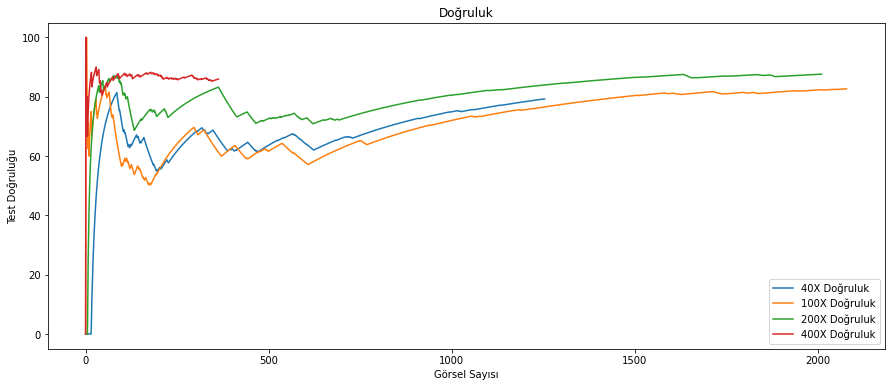

In [42]:
plt.figure(figsize=(15,6))
plt.plot(accList40X,label="40X Doğruluk")           # Accuracy rate for test of 40X magnification images
plt.plot(accList100X,label="100X Doğruluk")         # Accuracy rate for test of 100X magnification images
plt.plot(accList200X,label="200X Doğruluk")         # Accuracy rate for test of 200X magnification images
plt.plot(accuracyList400X,label="400X Doğruluk")    # Accuracy rate for test of 400X magnification images
plt.title('Doğruluk')                               
plt.xlabel('Görsel Sayısı')                         # Image counter (This label is incorrect)
plt.ylabel('Test Doğruluğu')                        # Accuracy Rate of Test
plt.legend()

# Precision Rate for Each Magnification Rates

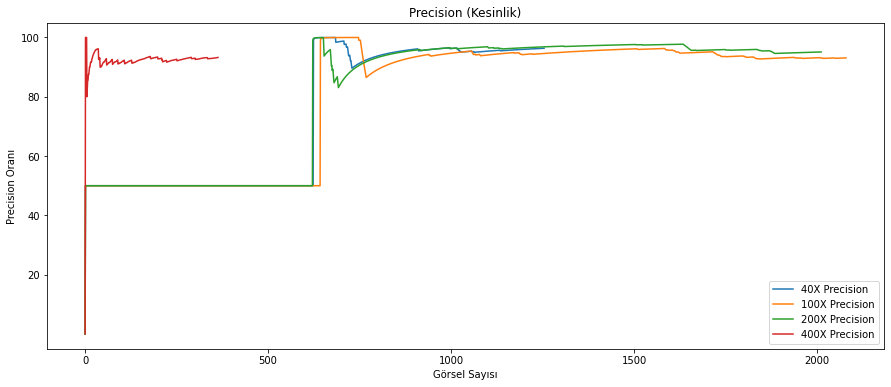

In [40]:
plt.figure(figsize=(15,6))
plt.plot(prList40X,label="40X Precision")            # Precision rate for test of 40X magnification images
plt.plot(prList100X,label="100X Precision")          # Precision rate for test of 100X magnification images
plt.plot(prList200X,label="200X Precision")          # Precision rate for test of 200X magnification images
plt.plot(precisionList400X,label="400X Precision")   # Precision rate for test of 400X magnification images
plt.title('Precision (Kesinlik)')                    
plt.xlabel('Görsel Sayısı')                          # Image counter (This label is incorrect)
plt.ylabel('Precision Oranı')                        # Precision rate
plt.yticks([20,40,60,80,100])
plt.legend()

# Recall Rate for Each Magnification Rates

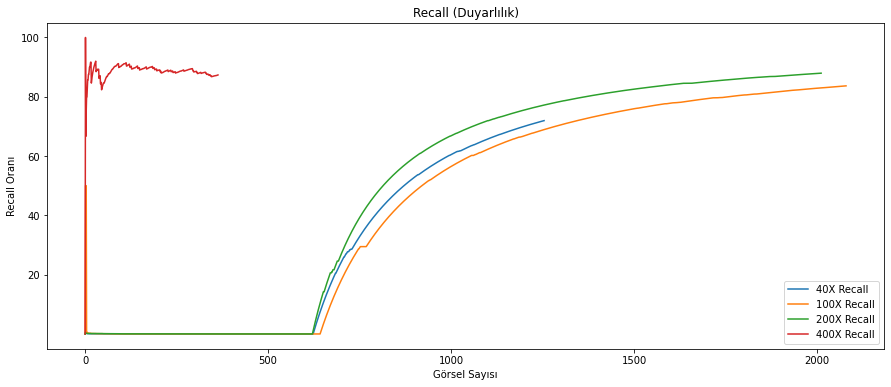

In [41]:
plt.figure(figsize=(15,6))
plt.plot(rList40X,label="40X Recall")                # Recall rate for test of 40X magnification images
plt.plot(rList100X,label="100X Recall")              # Recall rate for test of 100X magnification images
plt.plot(rList200X,label="200X Recall")              # Recall rate for test of 200X magnification images
plt.plot(recallList400X,label="400X Recall")         # Recall rate for test of 400X magnification images
plt.title('Recall (Duyarlılık)')
plt.xlabel('Görsel Sayısı')                          # Image counter (This label is incorrect)
plt.ylabel('Recall Oranı')                           # Recall rate
plt.yticks([20,40,60,80,100])
plt.legend()

# ROC Curve and AUC Score for Each Magnification Rates

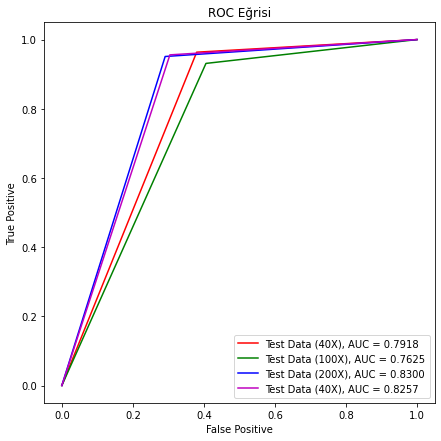

In [250]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr = 0,0
fpr40, tpr40, thresholds = roc_curve(tlList40X, pList40X)
fpr100, tpr100, thresholds = roc_curve(tlList100X, pList100X)
fpr200, tpr200, thresholds = roc_curve(tlList200X, pList200X)
fpr400, tpr400, thresholds = roc_curve(trueLabelList, predictedList)

auc40 = roc_auc_score(tlList40X, pList40X)
auc100 = roc_auc_score(tlList100X, pList100X)
auc200 = roc_auc_score(tlList200X, pList200X)
auc400 = roc_auc_score(trueLabelList, predictedList)

plt.figure(figsize=(7,7))
plt.title('ROC Eğrisi') # ROC Curve
plt.plot(fpr40,tpr40,label="Test Data (40X), AUC = "+str(auc40)[0:6], color="r")
plt.plot(fpr100,tpr100,label="Test Data (100X), AUC = "+str(auc100)[0:6], color="g")
plt.plot(fpr200,tpr200,label="Test Data (200X), AUC = "+str(auc200)[0:6], color="b")
plt.plot(fpr400,tpr400,label="Test Data (400X), AUC = "+str(auc400)[0:6], color="m")
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.legend()
plt.show()

# Saving the Model

In [90]:
checkpoint = {'state_dict': model.state_dict(),'optimizer' :optimizer.state_dict()}
torch.save(checkpoint, 'pyt-test6-400X.pth')